# Khai báo thư viện và load cơ sở dữ liệu


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Dense, Conv2D,Flatten,MaxPooling2D,AveragePooling2D,BatchNormalization,Reshape,TimeDistributed
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn import metrics
from datetime import datetime
import soundfile as sf
import os
import glob
import random
#import keras_tuner as kt

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

In [ ]:
feature_sets = np.load('/content/drive/MyDrive/wakeword/command_feature.npz')
X_train_data = feature_sets['x_train']
y_train_data = feature_sets['y_train']
X_val_data = feature_sets['x_val']
y_val_data = feature_sets['y_val']
X_test_data = feature_sets['x_test']
y_test_data = feature_sets['y_test']

In [ ]:
X_train_data.shape

(33496, 34, 36)

# Build mô hình MHAtt-RNN

In [ ]:
def model(input_shape,rnn_layers,rnn_units,heads,label_count):
  """BiRNN multihead attention model.

  It is based on paper:
  Attention Is All You Need
  https://papers.nips.cc/paper/7181-attention-is-all-you-need.pdf
  A neural attention model for speech command recognition
  https://arxiv.org/pdf/1808.08929.pdf

  """

  input_audio = tf.keras.layers.Input(input_shape)
  net = input_audio


  net = tf.keras.backend.expand_dims(net)


  net = tf.keras.layers.Conv2D(
        filters=10,
        kernel_size=(5,1),
        activation='relu',
        dilation_rate=(1,1),
        strides=(1,1),
        padding='same',
        activity_regularizer=tf.keras.regularizers.l2(1e-5),
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=tf.keras.regularizers.l2(1e-4)
        )(net)
  net = tf.keras.layers.BatchNormalization()(net)

  net = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=(5,1),
        activation='relu',
        dilation_rate=(1,1),
        strides=(1,1),
        padding='same',
        activity_regularizer=tf.keras.regularizers.l2(1e-5),
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=tf.keras.regularizers.l2(1e-4)
        )(net)
  net = tf.keras.layers.BatchNormalization()(net)

  shape = net.shape
  # input net dimension: [batch, time, feature, channels]
  # reshape dimension: [batch, time, feature * channels]
  # so that GRU/RNN can process it
  net = tf.keras.layers.Reshape((-1, shape[2] * shape[3]))(net)

  # dims: [batch, time, feature]
  for _ in range(rnn_layers):
    net = tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(rnn_units,
            return_sequences=True,
            unroll=True,
            activity_regularizer=tf.keras.regularizers.l2(1e-5),
            kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
            bias_regularizer=tf.keras.regularizers.l2(1e-4)))(
                net)
  feature_dim = net.shape[-1]
  middle = net.shape[1] // 2  # index of middle point of sequence

  # feature vector at middle point [batch, feature]
  mid_feature = net[:, middle, :]

  # prepare multihead attention
  multiheads = []
  for _ in range(heads):
    # apply one projection layer with the same dim as input feature
    query = tf.keras.layers.Dense(
        feature_dim,
        activity_regularizer=tf.keras.regularizers.l2(1e-5),
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=tf.keras.regularizers.l2(1e-4))(
            mid_feature)

    # attention weights [batch, time]
    att_weights = tf.keras.layers.Dot(axes=[1, 2])([query, net])
    att_weights = tf.keras.layers.Softmax()(att_weights)

    # apply attention weights [batch, feature]
    multiheads.append(tf.keras.layers.Dot(axes=[1, 1])([att_weights, net]))

  net = tf.keras.layers.concatenate(multiheads)

  net = tf.keras.layers.Dropout(rate=0.2)(net)


  net = tf.keras.layers.Dense(
        units=64,
        activation='relu',
        activity_regularizer=tf.keras.regularizers.l2(1e-5),
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=tf.keras.regularizers.l2(1e-4))(
            net)
  net = tf.keras.layers.Dense(
        units=32,
        activation='linear',
        activity_regularizer=tf.keras.regularizers.l2(1e-5),
        kernel_regularizer=tf.keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),
        bias_regularizer=tf.keras.regularizers.l2(1e-4))(
            net)
  net = tf.keras.layers.Dense(units=label_count)(net)
  net = tf.keras.layers.Activation('softmax')(net)
  return tf.keras.Model(input_audio, net)

Build mô hình MHAtt-RNN-S

In [ ]:
input_shape = (34,36)
rnn_layers = 1
rnn_units = 64
heads = 2
label_count = 6
MHAtt_RNN_S = model(input_shape,rnn_layers,rnn_units,heads,label_count)
MHAtt_RNN_S.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 34, 36)]             0         []                            
                                                                                                  
 tf.expand_dims (TFOpLambda  (None, 34, 36, 1)            0         ['input_1[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d (Conv2D)             (None, 34, 36, 10)           60        ['tf.expand_dims[0][0]']      
                                                                                                  
 batch_normalization (Batch  (None, 34, 36, 10)           40        ['conv2d[0][0]']          

Build mô hình MHAtt-RNN-M

In [ ]:
input_shape = (34,36)
rnn_layers = 2
rnn_units = 128
heads = 4
label_count = 6
MHAtt_RNN_M = model(input_shape,rnn_layers,rnn_units,heads,label_count)
MHAtt_RNN_M.summary()

Compile và Train model

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-4)
MHAtt_RNN_M.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer= opt)

In [ ]:
tensorboard = TensorBoard(log_dir="logs")
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_command_model.h5',
                                                         save_best_only=True,
                                                         save_weights_only=False,
                                                         monitor='loss',
                                                         mode='min',
                                                         verbose=1)
batch_size = 128
epochs = 500
# train the model using the training set and validating using validation set
history = MHAtt_RNN_M.fit(X_train_data, y_train_data, epochs=epochs, batch_size=batch_size,
          callbacks=[tensorboard,checkpoint_callback])

Epoch 1/500
320/320 [==============================] - ETA: 0s - loss: 1.1740 - accuracy: 0.7557
Epoch 1: loss improved from inf to 1.17397, saving model to best_command_model.h5
320/320 [==============================] - 63s 71ms/step - loss: 1.1740 - accuracy: 0.7557
Epoch 2/500
  1/320 [..............................] - ETA: 22s - loss: 0.8797 - accuracy: 0.8750

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


320/320 [==============================] - ETA: 0s - loss: 0.8034 - accuracy: 0.8691
Epoch 2: loss improved from 1.17397 to 0.80341, saving model to best_command_model.h5
320/320 [==============================] - 23s 71ms/step - loss: 0.8034 - accuracy: 0.8691
Epoch 3/500
320/320 [==============================] - ETA: 0s - loss: 0.7071 - accuracy: 0.9004
Epoch 3: loss improved from 0.80341 to 0.70708, saving model to best_command_model.h5
320/320 [==============================] - 25s 79ms/step - loss: 0.7071 - accuracy: 0.9004
Epoch 4/500
320/320 [==============================] - ETA: 0s - loss: 0.6459 - accuracy: 0.9178
Epoch 4: loss improved from 0.70708 to 0.64593, saving model to best_command_model.h5
320/320 [==============================] - 23s 72ms/step - loss: 0.6459 - accuracy: 0.9178
Epoch 5/500
320/320 [==============================] - ETA: 0s - loss: 0.5973 - accuracy: 0.9332
Epoch 5: loss improved from 0.64593 to 0.59726, saving model to best_command_model.h5
320/320

# Đánh giá kết quả của mô hình

Vẽ biểu đồ loss và accuracy của mô hình trong quá trình train

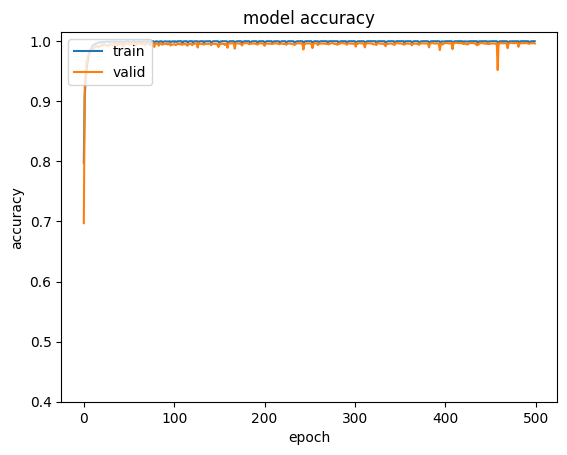

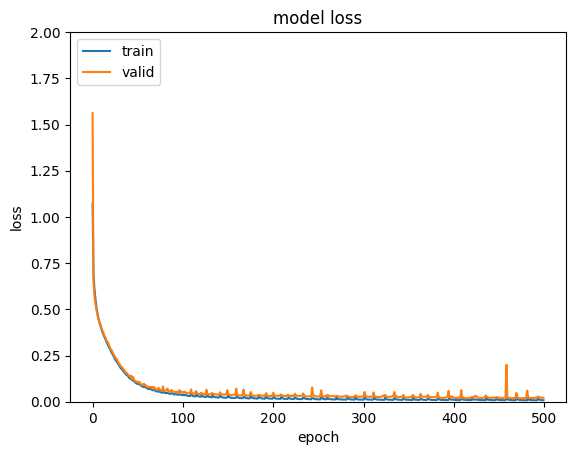

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylim(0.4, )
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.ylim(0, 2)
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

Đánh giá mô hình trên tập dữ liệu test

In [ ]:
keras_model.evaluate(X_test_data,y_test_data)

131/131 [==============================] - 7s 21ms/step - loss: 0.0299 - accuracy: 0.9955


[0.029896996915340424, 0.9954632520675659]

In [ ]:
keras_model = tf.keras.models.load_model("/content/best_command_model.h5")
from sklearn.metrics import classification_report
pre = []
for features in tqdm(X_test_data):
  features = features.reshape(1,34,36)
  preds = keras_model.predict(features,verbose=0)
  pred = preds[0]
  if list(pred).index(max(pred))==0:
    pre.append([1,0,0,0,0,0])
  elif list(pred).index(max(pred))==1:
    pre.append([0,1,0,0,0,0])
  elif list(pred).index(max(pred))==2:
    pre.append([0,0,1,0,0,0])
  elif list(pred).index(max(pred))==3:
    pre.append([0,0,0,1,0,0])
  elif list(pred).index(max(pred))==4:
    pre.append([0,0,0,0,1,0])
  elif list(pred).index(max(pred))==5:
    pre.append([0,0,0,0,0,1])
print(classification_report(y_test_data,pre))

100%|██████████| 4188/4188 [05:35<00:00, 12.49it/s]

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       286
           1       1.00      1.00      1.00       296
           2       1.00      0.98      0.99       270
           3       0.98      0.99      0.99       280
           4       0.98      0.99      0.98       239
           5       1.00      1.00      1.00      2817

   micro avg       1.00      1.00      1.00      4188
   macro avg       0.99      0.99      0.99      4188
weighted avg       1.00      1.00      1.00      4188
 samples avg       1.00      1.00      1.00      4188



In [ ]:
def decode_label(pred):
  label = list(pred).index(max(pred))
  if label == 0:
    return 'den bat'
  elif label == 1:
    return 'den chuyen mau'
  elif label == 2:
    return 'den giam sang'
  elif label == 3:
    return 'den tang sang'
  elif label == 4:
    return 'den tat'
  elif label == 5:
    return 'noise'
ground_true = []
preds = []
for i in range(0,len(y_test_data)):
  ground_true.append(decode_label(y_test_data[i]))
  feature = X_test_data[i].reshape(1,34,36)
  pre = keras_model.predict(feature,verbose=0)
  result = decode_label(pre[0])
  preds.append(result)

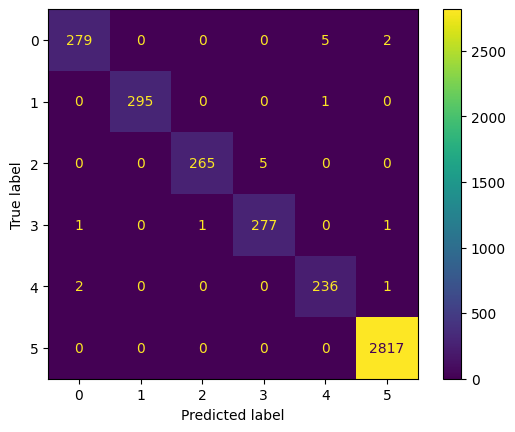

In [ ]:
conf_matrix = confusion_matrix(ground_true,preds)
disp = ConfusionMatrixDisplay( confusion_matrix=conf_matrix)
disp.plot()
plt.show()

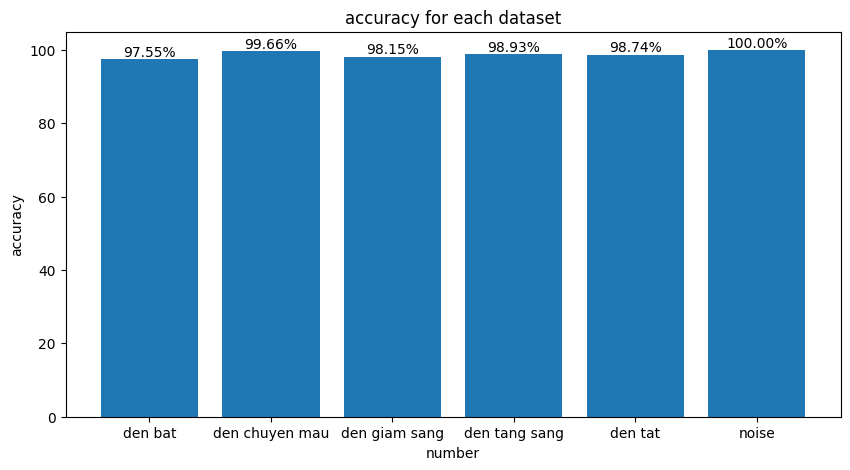

In [ ]:
acc_per = []
for i in range(0,6):
  sum_label = 0
  for j in range(0,6):
    sum_label = sum_label + conf_matrix[i][j]
  accu = float(conf_matrix[i][i]/sum_label)
  acc_per.append(round(accu,4)*100)
labels =  ['den bat','den chuyen mau','den giam sang','den tang sang','den tat','noise']
plt.figure(figsize=(10,5))
plt.bar(labels,acc_per)
for i in range(len(labels)):
    plt.text(labels[i], acc_per[i], f"{acc_per[i]:.2f}"+"%", ha='center', va='bottom')
plt.xlabel("number")
plt.ylabel("accuracy")
plt.title("accuracy for each dataset")
plt.show()

# chuyển đổi mô hình sang Tensorflow Lite

In [ ]:
# Load model keras
keras_model = tf.keras.models.load_model("/content/best_command_model.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model_quantize_f16 = converter.convert()


with open("/content/drive/MyDrive/saved_model/mha_rnn_final.tflite", "wb") as f:
    f.write(tflite_model_quantize_f16)